In [1]:
# 2301980530

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import shutil
import torch
import torchvision
import torch.nn as nn
import time
import copy

from glob import glob
from torchvision import transforms, models, datasets
from torch.autograd import Variable
from torch import optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.functional import precision_recall, average_precision

%matplotlib inline

In [2]:
# CUDA GPU availability
torch.cuda.is_available()

True

In [3]:
# validate dataset folder directory

dir = 'D:/kampus/S2/Deep learning/UAS/No1'

print(os.listdir('D:/kampus/S2/Deep learning/UAS/No1'))
print(os.listdir('D:/kampus/S2/Deep learning/UAS/No1/train'))
print(os.listdir('D:/kampus/S2/Deep learning/UAS/No1/test'))
print(os.listdir('D:/kampus/S2/Deep learning/UAS/No1/validation'))

['bird-classification.ipynb', 'birds latin names.csv', 'birds.csv', 'class_dict.csv', 'EfficientNetB4-BIRDS-0.99.h5', 'my_csv-2-17-2022-1-17-48.csv', 'tensorboard', 'test', 'train', 'validation']
['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ALBATROSS']
['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ALBATROSS']
['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ALBATROSS']


In [4]:
# Data augmentation and normalization for training
# Just normalization for validation and test

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
img_datasets = {x: datasets.ImageFolder(os.path.join(dir, x),
                                        data_transforms[x])
                for x in ['train', 'test', 'validation']}

data_loaders = {x: torch.utils.data.DataLoader(img_datasets[x], batch_size=6,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'test', 'validation']}

datasets_size = {x: len(img_datasets[x]) for x in ['train', 'test', 'validation']}

class_names = img_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# visualize img dataset

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

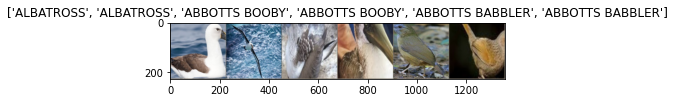

In [7]:
inputs, classes = next(iter(data_loaders['train']))
inputs, classes = inputs.cuda(), classes.cuda()
grid = torchvision.utils.make_grid(inputs)

imshow(grid, title=[class_names[x] for x in classes])


In [8]:
# input to tensorboard

writer = SummaryWriter('D:/kampus/S2/Deep learning/UAS/No1/tensorboard')

writer.add_image('birds_img', grid)
writer.close()

In [9]:
# generic function for training model
# schedulling lr and saving best model

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / datasets_size[phase]
            epoch_acc = running_corrects.double() / datasets_size[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            writer.add_scalar(f'{phase}_loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase}_acc', epoch_acc, epoch)

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
# Generic function to display predictions for a few images

def visualize_model(model, num_images=2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    precision = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            precision = precision_recall(preds, labels, average='macro', num_classes=3)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}\nreal: {class_names[labels[j]]}\nprecision: {precision[j]}')

                imshow(inputs.data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
# call the pretrained architecture

model_ft_pretrained = models.resnet18(weights='ResNet18_Weights.DEFAULT')
num_ftrs = model_ft_pretrained.fc.in_features

model_ft_pretrained.fc = nn.Linear(num_ftrs, 3)

model_ft_pretrained = model_ft_pretrained.to(device)

In [12]:
# fine tunning parameter

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft_pretrained.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduller = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
writer.add_graph(model_ft_pretrained, inputs)
writer.close()

In [14]:
# train and evaluate model

model_ft_pretrained = train_model(model_ft_pretrained, criterion,
                                  optimizer_ft, exp_lr_scheduller, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5959 Acc: 0.7286
validation Loss: 0.2272 Acc: 0.9333

Epoch 1/9
----------
train Loss: 0.4412 Acc: 0.8142
validation Loss: 0.0790 Acc: 1.0000

Epoch 2/9
----------
train Loss: 0.3844 Acc: 0.8413
validation Loss: 0.3281 Acc: 0.8667

Epoch 3/9
----------
train Loss: 0.3490 Acc: 0.8580
validation Loss: 0.0624 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.3344 Acc: 0.8559
validation Loss: 0.0495 Acc: 1.0000

Epoch 5/9
----------
train Loss: 0.3495 Acc: 0.8518
validation Loss: 0.1798 Acc: 0.9333

Epoch 6/9
----------
train Loss: 0.2715 Acc: 0.9102
validation Loss: 0.0672 Acc: 0.9333

Epoch 7/9
----------
train Loss: 0.3338 Acc: 0.8664
validation Loss: 0.0272 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.2448 Acc: 0.9040
validation Loss: 0.0142 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.1804 Acc: 0.9478
validation Loss: 0.0267 Acc: 1.0000

Training complete in 2m 10s
Best val Acc: 1.000000


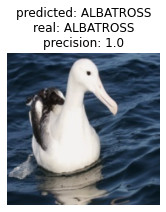

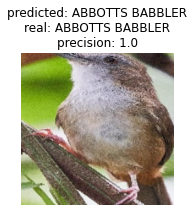

In [26]:
visualize_model(model_ft_pretrained)

In [16]:
# call the architecture for training from scratch

model_ft_sc = models.resnet18(weights=None)
num_ftrs = model_ft_sc.fc.in_features

model_ft_sc.fc = nn.Linear(num_ftrs, 3)

model_ft_sc = model_ft_sc.to(device)

In [17]:
# fine tunning parameter

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft_sc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduller = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:
writer.add_graph(model_ft_sc, inputs)
writer.close()

In [19]:
# train and evaluate model

model_ft_sc = train_model(model_ft_sc, criterion,
                                  optimizer_ft, exp_lr_scheduller, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.0087 Acc: 0.5240
validation Loss: 0.7590 Acc: 0.7333

Epoch 1/9
----------
train Loss: 0.9045 Acc: 0.5637
validation Loss: 0.9250 Acc: 0.6000

Epoch 2/9
----------
train Loss: 0.8201 Acc: 0.6200
validation Loss: 0.7251 Acc: 0.5333

Epoch 3/9
----------
train Loss: 0.8266 Acc: 0.6117
validation Loss: 0.6378 Acc: 0.6667

Epoch 4/9
----------
train Loss: 0.9451 Acc: 0.5804
validation Loss: 0.5632 Acc: 0.8667

Epoch 5/9
----------
train Loss: 0.8461 Acc: 0.5992
validation Loss: 0.9854 Acc: 0.4667

Epoch 6/9
----------
train Loss: 0.8270 Acc: 0.5971
validation Loss: 0.6399 Acc: 0.8667

Epoch 7/9
----------
train Loss: 0.7573 Acc: 0.6639
validation Loss: 0.6241 Acc: 0.8000

Epoch 8/9
----------
train Loss: 0.7463 Acc: 0.6597
validation Loss: 0.6452 Acc: 0.6667

Epoch 9/9
----------
train Loss: 0.7068 Acc: 0.7098
validation Loss: 0.6735 Acc: 0.8000

Training complete in 2m 14s
Best val Acc: 0.866667


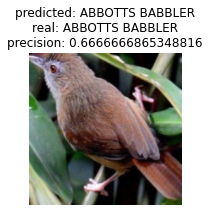

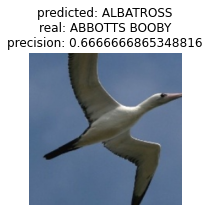

In [27]:
# test model that trained from scratch

visualize_model(model_ft_sc)

In [28]:
# transfer learning with freezing layer exept final layer

model_conv = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')

for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features

model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

In [29]:
# fine tunning parameter

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft_sc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduller = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [30]:
writer.add_graph(model_conv, inputs)
writer.close()

In [31]:
# train and evaluate model

model_conv = train_model(model_conv, criterion,
                                  optimizer_ft, exp_lr_scheduller, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.3125 Acc: 0.3090
validation Loss: 1.7291 Acc: 0.2667

Epoch 1/9
----------
train Loss: 1.2984 Acc: 0.3299
validation Loss: 1.7162 Acc: 0.2667

Epoch 2/9
----------
train Loss: 1.3235 Acc: 0.3278
validation Loss: 1.7099 Acc: 0.2667

Epoch 3/9
----------
train Loss: 1.3091 Acc: 0.3382
validation Loss: 1.6947 Acc: 0.3333

Epoch 4/9
----------
train Loss: 1.3112 Acc: 0.3319
validation Loss: 1.6109 Acc: 0.2667

Epoch 5/9
----------
train Loss: 1.3242 Acc: 0.3152
validation Loss: 1.6702 Acc: 0.2667

Epoch 6/9
----------
train Loss: 1.3285 Acc: 0.3152
validation Loss: 1.7139 Acc: 0.3333

Epoch 7/9
----------
train Loss: 1.2870 Acc: 0.3319
validation Loss: 1.6968 Acc: 0.2667

Epoch 8/9
----------
train Loss: 1.3242 Acc: 0.3194
validation Loss: 1.7106 Acc: 0.2667

Epoch 9/9
----------
train Loss: 1.3214 Acc: 0.3278
validation Loss: 1.6628 Acc: 0.3333

Training complete in 2m 1s
Best val Acc: 0.333333


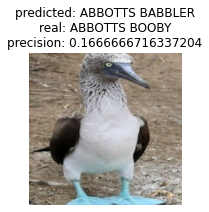

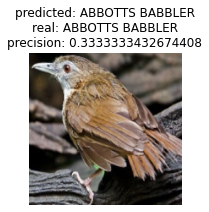

In [32]:
# test model that using transfer learning and freezing layer exept final layer

visualize_model(model_conv)

In [11]:
# training resnet TF with certain layer freezed

model_conv_1 = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')

# find layer name that will be freezed
for name, p in model_conv_1.named_parameters():
  print('param name: ', name, 'requires_grad: ', p.requires_grad)

param name:  conv1.weight requires_grad:  True
param name:  bn1.weight requires_grad:  True
param name:  bn1.bias requires_grad:  True
param name:  layer1.0.conv1.weight requires_grad:  True
param name:  layer1.0.bn1.weight requires_grad:  True
param name:  layer1.0.bn1.bias requires_grad:  True
param name:  layer1.0.conv2.weight requires_grad:  True
param name:  layer1.0.bn2.weight requires_grad:  True
param name:  layer1.0.bn2.bias requires_grad:  True
param name:  layer1.1.conv1.weight requires_grad:  True
param name:  layer1.1.bn1.weight requires_grad:  True
param name:  layer1.1.bn1.bias requires_grad:  True
param name:  layer1.1.conv2.weight requires_grad:  True
param name:  layer1.1.bn2.weight requires_grad:  True
param name:  layer1.1.bn2.bias requires_grad:  True
param name:  layer2.0.conv1.weight requires_grad:  True
param name:  layer2.0.bn1.weight requires_grad:  True
param name:  layer2.0.bn1.bias requires_grad:  True
param name:  layer2.0.conv2.weight requires_grad:  True

In [12]:
# freez the certain layer

for name, p in model_conv_1.named_parameters():
  if name == 'conv1.weight':
    p.requires_grad = True
  
  elif name == 'fc.weight':
    p.requires_grad = True

  else:
    p.requires_grad = False

  print('param name: ', name, 'requires_grad: ', p.requires_grad)

param name:  conv1.weight requires_grad:  True
param name:  bn1.weight requires_grad:  False
param name:  bn1.bias requires_grad:  False
param name:  layer1.0.conv1.weight requires_grad:  False
param name:  layer1.0.bn1.weight requires_grad:  False
param name:  layer1.0.bn1.bias requires_grad:  False
param name:  layer1.0.conv2.weight requires_grad:  False
param name:  layer1.0.bn2.weight requires_grad:  False
param name:  layer1.0.bn2.bias requires_grad:  False
param name:  layer1.1.conv1.weight requires_grad:  False
param name:  layer1.1.bn1.weight requires_grad:  False
param name:  layer1.1.bn1.bias requires_grad:  False
param name:  layer1.1.conv2.weight requires_grad:  False
param name:  layer1.1.bn2.weight requires_grad:  False
param name:  layer1.1.bn2.bias requires_grad:  False
param name:  layer2.0.conv1.weight requires_grad:  False
param name:  layer2.0.bn1.weight requires_grad:  False
param name:  layer2.0.bn1.bias requires_grad:  False
param name:  layer2.0.conv2.weight req

In [13]:
num_ftrs = model_conv_1.fc.in_features

model_conv_1.fc = nn.Linear(num_ftrs, 3)

model_conv_1 = model_conv_1.to(device)

In [14]:
# fine tunning parameter

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_conv_1.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduller = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
writer.add_graph(model_conv_1, inputs)
writer.close()

In [16]:
# train and evaluate model

model_conv_fc = train_model(model_conv_1, criterion,
                                  optimizer_ft, exp_lr_scheduller, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.7787 Acc: 0.6159
validation Loss: 0.4372 Acc: 0.8000

Epoch 1/9
----------
train Loss: 0.5404 Acc: 0.7704
validation Loss: 0.2750 Acc: 0.9333

Epoch 2/9
----------
train Loss: 0.4589 Acc: 0.8017
validation Loss: 0.1934 Acc: 1.0000

Epoch 3/9
----------
train Loss: 0.4272 Acc: 0.8288
validation Loss: 0.1642 Acc: 0.9333

Epoch 4/9
----------
train Loss: 0.4494 Acc: 0.8184
validation Loss: 0.3490 Acc: 0.8000

Epoch 5/9
----------
train Loss: 0.5106 Acc: 0.7975
validation Loss: 0.1256 Acc: 0.9333

Epoch 6/9
----------
train Loss: 0.4745 Acc: 0.8017
validation Loss: 0.0908 Acc: 1.0000

Epoch 7/9
----------
train Loss: 0.3922 Acc: 0.8392
validation Loss: 0.1289 Acc: 0.9333

Epoch 8/9
----------
train Loss: 0.3447 Acc: 0.8622
validation Loss: 0.1347 Acc: 0.9333

Epoch 9/9
----------
train Loss: 0.3790 Acc: 0.8330
validation Loss: 0.1069 Acc: 1.0000

Training complete in 2m 5s
Best val Acc: 1.000000


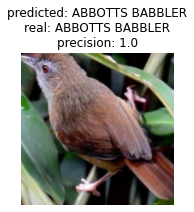

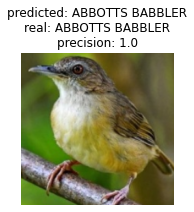

In [17]:
# test model

visualize_model(model_conv_fc)

In [32]:
# training from scratch with increased learning rate

model_sc_lr = models.resnet18(weights=None)
num_ftrs = model_sc_lr.fc.in_features

model_sc_lr.fc = nn.Linear(num_ftrs, 3)

model_sc_lr = model_sc_lr.to(device)

In [33]:
# fine tunning parameter

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_sc_lr.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduller = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [34]:
writer.add_graph(model_sc_lr, inputs)
writer.close()

In [35]:
# train and evaluate model

model_sc_lr = train_model(model_sc_lr, criterion,
                                  optimizer_ft, exp_lr_scheduller, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.7718 Acc: 0.4760
validation Loss: 5.0094 Acc: 0.6667

Epoch 1/9
----------
train Loss: 1.2735 Acc: 0.5261
validation Loss: 0.5592 Acc: 0.8000

Epoch 2/9
----------
train Loss: 1.1513 Acc: 0.5574
validation Loss: 0.8327 Acc: 0.5333

Epoch 3/9
----------
train Loss: 1.0411 Acc: 0.5261
validation Loss: 0.7385 Acc: 0.6667

Epoch 4/9
----------
train Loss: 0.9167 Acc: 0.5699
validation Loss: 0.7929 Acc: 0.4667

Epoch 5/9
----------
train Loss: 0.9034 Acc: 0.5825
validation Loss: 0.6952 Acc: 0.6667

Epoch 6/9
----------
train Loss: 0.8779 Acc: 0.5992
validation Loss: 0.7342 Acc: 0.6000

Epoch 7/9
----------
train Loss: 0.7887 Acc: 0.6305
validation Loss: 0.7223 Acc: 0.7333

Epoch 8/9
----------
train Loss: 0.7562 Acc: 0.6555
validation Loss: 0.6202 Acc: 0.8000

Epoch 9/9
----------
train Loss: 0.8106 Acc: 0.6409
validation Loss: 0.6859 Acc: 0.7333

Training complete in 2m 15s
Best val Acc: 0.800000


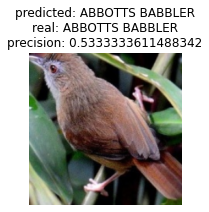

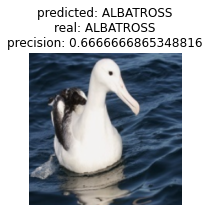

In [37]:
# test model

visualize_model(model_sc_lr)